# Step 0: Import Libraries and Configure Settings

This cell:
1. Imports various Python libraries for data manipulation, visualization, and machine learning.
2. Configures warning filters and matplotlib settings.
3. Ensures that Pandas displays all columns.

In [72]:
# Standard library imports
import warnings

# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics and data preprocessing
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.metrics import (
    pairwise_distances, 
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    KFold, 
    cross_val_score
)
from mpl_toolkits.mplot3d import Axes3D

# Miscellaneous settings
warnings.filterwarnings('ignore')
%matplotlib inline
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

#test 123

In [73]:
pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', None)

# Step 1: Load and Inspect the Data

This cell:
1. Reads the CSV file into a Pandas DataFrame.
2. Performs a quick check of the DataFrame shape.
3. Splits the dataset into two classes (class0 and class1) by taking the first 2500 rows as one class and the last 2500 rows as another.
4. Shows a simple descriptive analysis for each class.

In [74]:
file = 'trainData/53_train.csv'
df_train = pd.read_csv(file, header=None)


file_test = 'trainData/53_test.csv'
df_test = pd.read_csv(file_test, header=None)


In [75]:
df_train.shape

(5000, 72)

In [76]:
df_test.shape

(50000, 72)

In [77]:
class0 = df_train.head(2500)
class1 = df_train.tail(2500)


# Step 2: Replace Zeros with Column Means

This cell:
1. Replaces zero values in each class with the mean of its respective column.
2. Displays the updated DataFrame for both classes.


In [78]:
class0.replace(0, class0.mean(axis=0), inplace=True)

df_test.replace(0, df_test.mean(axis=0), inplace=True)


In [79]:
class1.replace(0, class1.mean(axis=0), inplace=True)

# Step 3: Apply PCA for Dimensionality Reduction

This cell:
1. Creates separate PCA objects for class0 and class1, each capturing 95% of the variance.
2. Fits and transforms the data for both classes.
3. Combines the two classes into one dataset and applies PCA to the combined dataset as well.
4. Splits the transformed PCA data back into two separate sets for class0 and class1.
5. Prints the shape of the transformed class0 data as an example.

In [80]:
pca_class0 = PCA(n_components=0.95)
pca_class1 = PCA(n_components=0.95)

class0_pca = pca_class0.fit_transform(class0)
class1_pca = pca_class1.fit_transform(class1)

print(class0_pca.shape)



(2500, 41)


In [81]:
pca_test = PCA(n_components=0.95)

class_pca_test = pca_test.fit_transform(df_test)

print(pca_test)

PCA(n_components=0.95)


In [82]:
combined_data = np.vstack((class0, class1))
pca = PCA(n_components=0.95)
combined_pca = pca.fit_transform(combined_data)
class0_pca, class1_pca = combined_pca[:len(class0)], combined_pca[len(class0):]


Now dat we have our data in PCA space, with the most variance, we can train multiple learning models and look at what fits the data best. The decision of what the best fit is will be taking by most likely the largest Area Under ROC curve. Since this will give us the highest true positive rate.

Our pre expectations are that linear learning models will not perform as good non linear models (i.e. random fores, CNN), sine the data seems to have a large amount of variance in it.

For each learner The according packages are loaded in in each cell

# Step 4:

This cell:
1. Stacks the PCA-transformed data for both classes.
2. Creates a label array (Y) where 0 corresponds to `class0_pca` and 1 to `class1_pca`.
3. Splits the data into training and testing sets.
4. Trains a Logistic Regression model on the training data.
5. Makes predictions (both predicted class and predicted probabilities).
6. Computes and prints the confusion matrix.
7. Computes and prints the ROC AUC score.
8. Plots the ROC curve.


Confusion Matrix:
[[450  50]
 [ 60 440]]
Area Under the Curve (AUC): 0.9495399999999999


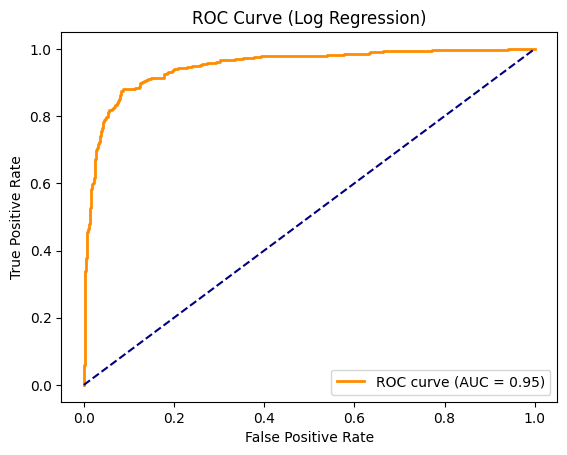

In [83]:
X = np.vstack((class0_pca, class1_pca))
Y = np.array([0] * len(class0_pca) + [1] * len(class1_pca))

# Proceed with train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Use probability for class 1
y_pred = (y_pred_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Area Under the Curve (AUC):", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Log Regression)')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
[[ 62 438]
 [455  45]]
Area Under the Curve (AUC): 0.949668


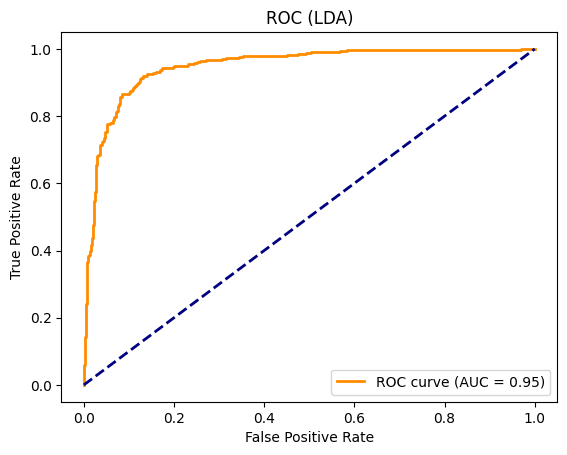

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Data setup
X = np.vstack((class0_pca, class1_pca))
y = np.array([1] * 2500 + [0] * 2500)  # Swap labels for inverse logic

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the LDA model
lda = LDA()
lda.fit(X_train, y_train)

# Make predictions
y_pred_proba = 1 - lda.predict_proba(X_test)[:, 0]  # Inverse probabilities
y_pred = (y_pred_proba < 0.5).astype(int)  # Reverse classification threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Area Under the Curve (AUC): {roc_auc}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (LDA)")
plt.legend(loc="lower right")
plt.show()


# Step 5: Linear Discriminant Analysis (LDA)

This cell:
1. Re-stacks the PCA-transformed data and creates labels (this time switching the order of classes, just as an example).
2. Splits the data into training and testing sets.
3. Trains an LDA model on the training data.
4. Makes predictions and calculates the confusion matrix.
5. Computes and prints the ROC AUC score.
6. Plots the ROC curve.
7. Saves the prediction probabilities and classes to a CSV file.
8. Shows a pie chart of the predicted class distribution.


# Step 6: Decision Tree Classifier

This cell:
1. Prepares the data again for the decision tree (stacked PCA data, labels [0,1]).
2. Splits the data into training and testing sets.
3. Trains a Decision Tree classifier with a specified `max_depth`.
4. Predicts on the test set and calculates accuracy, ROC AUC, and confusion matrix.
5. Plots the ROC curve.
6. Saves predictions to a CSV file.
7. Plots a pie chart of the predicted class distribution.


Accuracy: 0.81


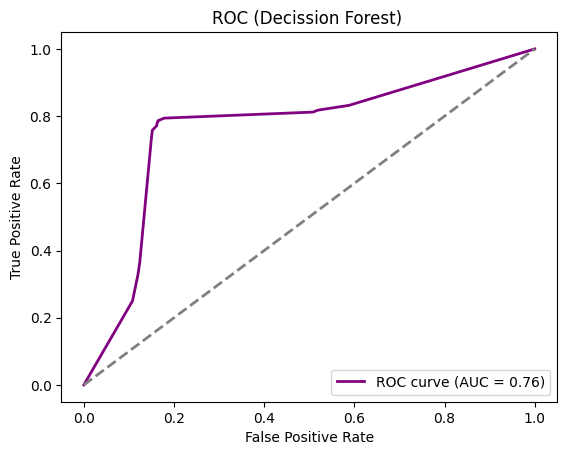

AUC: 0.76


In [85]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_curve, auc
#decission tree Step + Confusion matrix of decission tree + AOG of decission tree


X = np.vstack((class0_pca, class1_pca))
y = np.array([0] * 2500 + [1] * 2500)

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=11)  
clf.fit(X_train, y_train)

# Step 2: Make predictions and evaluate
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]  

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


# Step 4: Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Step 5: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Decission Forest) ')
plt.legend(loc="lower right")
plt.show()

# AUC result
print(f"AUC: {roc_auc:.2f}")



# Step 7: Random Forest Classifier

This cell:
1. Reshapes (flattens) the PCA data just in case (not strictly necessary for Random Forest, but often done).
2. Standardizes (scales) the data (though RF is less sensitive to scaling).
3. Trains a Random Forest classifier.
4. Evaluates model performance (accuracy, confusion matrix, ROC AUC).
5. Plots the ROC curve.
6. Saves predictions to a CSV file.
7. Plots the predicted class distribution as a pie chart.


Test Accuracy: 0.92
Confusion Matrix:
[[463  37]
 [ 43 457]]
Area Under the Curve (AUC): 0.98


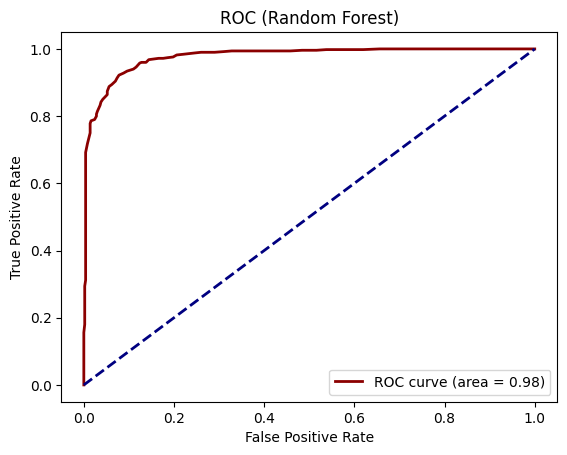

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Flatten the data (Random Forest does not require channel dimensions)
X_flat = X.reshape(X.shape[0], -1)

# Train-test split
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

# (Optional) Standardize the data for better performance (though Random Forest is less sensitive to scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)  
rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1] 

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Area Under the Curve (AUC): {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='DarkRed', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Random Forest)")
plt.legend(loc="lower right")
plt.show()


Random Forest predictions saved to df_test_rf_predictions_final.csv


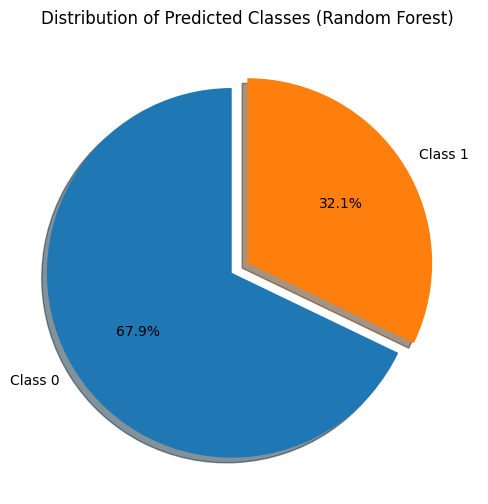

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Assuming df_test is a DataFrame and preprocessing is similar to training data
df_test_array = df_test.to_numpy()

# Step 1: Apply PCA if used during training
if 'pca' in globals():
    df_test_array = pca.transform(df_test_array)  # Reduce to the same dimensions as training data

# Step 2: Apply StandardScaler if used during training
if 'scaler' in globals():
    df_test_array = scaler.transform(df_test_array) 

# Step 3: Predict using the trained Random Forest model
rf_proba = rf.predict_proba(df_test_array)[:, 1] 
rf_pred = rf.predict(df_test_array)             

# Step 4: Save predictions to CSV
df_test_results = pd.DataFrame({
    "rf_pred": rf_pred,
    "rf_proba": rf_proba
})
output_path = "df_test_rf_predictions_final.csv"
df_test_results.to_csv(output_path, index=False)
print(f"Random Forest predictions saved to {output_path}")

# Step 5: Plot distribution of predicted classes
rf_class_counts = pd.Series(rf_pred).value_counts()
plt.figure(figsize=(6, 6))
rf_class_counts.plot.pie(
    autopct='%1.1f%%',
    labels=['Class 0', 'Class 1'],  
    startangle=90,
    explode=(0.1, 0), 
    shadow=True
)
plt.title("Distribution of Predicted Classes (Random Forest)")
plt.ylabel("")  
plt.show()


Random forest uses multiple decission tree's with bagging. Resulting in the most powerfull classifier on our data set


# Step 8: K-Nearest Neighbors (KNN)

This cell:
1. Again flattens and standardizes the data.
2. Trains a KNN classifier (with `n_neighbors=5`).
3. Evaluates model performance (accuracy, confusion matrix, ROC AUC).
4. Plots the ROC curve.
5. Saves predictions to a CSV file.
6. Plots the predicted class distribution as a pie chart.

Test Accuracy: 0.92
Confusion Matrix:
[[444  56]
 [ 25 475]]
Area Under the Curve (AUC): 0.97


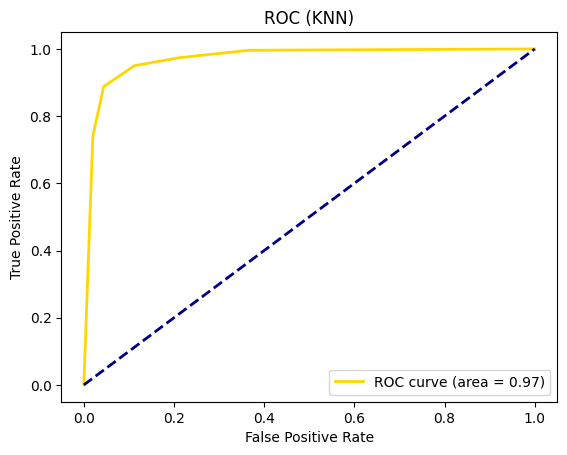

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt

# Flatten the data (KNN does not require channel dimensions)
X_flat = X.reshape(X.shape[0], -1)

# Train-test split
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn.predict(X_test_scaled)
y_pred_proba = knn.predict_proba(X_test_scaled)[:, 1]  
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"Area Under the Curve (AUC): {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='gold', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (KNN)")
plt.legend(loc="lower right")
plt.show()


A slow learner like Knn appears to give us also a large area under curve. 